In [44]:
import datetime
import numpy as np
import pandas as pd

# 20200330

In [45]:
c14_patient_data = pd.read_excel('../../../data/C14data_liver_samples_20200330.xlsx').sort_values('sample')

In [46]:
len(c14_patient_data)

105

In [47]:
ploidy_purity = pd.read_excel('../../../data/ploidy purity.xlsx', usecols=[1, 2, 3, 4, 5])
ploidy_purity = ploidy_purity.rename({'ID': 'sample',
                                      'population sorted': 'sort',
                                      '2n': '2n contamination %',
                                      '4n': '4n contamination %',
                                      'NPC': 'NPC contamination %'},
                                     axis='columns')
ploidy_purity['sort'] = [f'{sort} hepatocyte' for sort in ploidy_purity['sort']]
ploidy_purity['ploidy_purity %'] = 100 - ploidy_purity.fillna(value=0)[['2n contamination %', '4n contamination %']].sum(axis='columns')

In [48]:
ploidy_purity.head()

,sample,sort,2n contamination %,4n contamination %,NPC contamination %,ploidy_purity %
0,ND383,2n hepatocyte,NaN,2.0,3.00,98.0
1,ND383,4n hepatocyte,12.5,NaN,1.90,87.5
2,HL#11,2n hepatocyte,NaN,6.0,2.60,94.0
3,HL#11,4n hepatocyte,13.0,NaN,5.00,87.0
4,ND255,2n hepatocyte,NaN,2.9,5.55,97.1


In [49]:
c14_patient_data = c14_patient_data.merge(ploidy_purity, how='left')

In [50]:
len(c14_patient_data)

105

In [51]:
# c14_patient_data['Δ 14C corr'] = c14_patient_data['Δ 14C']

## Purity correction

Which cases can we correct?

In [52]:
(c14_patient_data
 .query('sort != "unsorted"')
 .groupby(['sample'])
 .filter(lambda df: len(df) > 1)
 .groupby(['sample'])
 .agg({'sort': lambda s: tuple(s.sort_values())})
 ['sort'].unique()
)

array([('2n hepatocyte', '4n hepatocyte'),
       ('hepatocyte', 'non-hepatocyte'), ('2n hepatocyte', 'hepatocyte'),
       ('2n hepatocyte', '4n hepatocyte', 'hepatocyte'),
       ('2n hepatocyte', '2n hepatocyte', '4n hepatocyte', 'non-hepatocyte')],
      dtype=object)

We can correct for:

- 'hepatocyte' vs 'non-hepatocyte'
- '2n hepatocyte' vs '4n hepatocyte'
- '2n hepatocyte' vs '4n hepatocyte' vs 'non-hepatocyte'

See Mathematica notebook `purity correction` for derivation of the formulas

Be carefull with this sample which has two 2n sorts:

In [53]:
c14_patient_data.groupby(['sample', 'sort']).filter(lambda x: len(x) > 1)

,Code,sample,DOB,DOA,sex,% hepa,% non-hepa,% hepa -> 100%,% 2n,% 4n,...,no sorted,purity %,Δ 14C,"Error, 2 s",Pathology,comment,2n contamination %,4n contamination %,NPC contamination %,ploidy_purity %
50,PH90,ND383,1937.583333,2016.666667,F,NaN,NaN,NaN,69.0,27.0,...,68 mio,93.0,41.2,10.5,N,3 sorts,NaN,2.0,3.0,98.0
53,PH89,ND383,1937.583333,2016.666667,F,NaN,NaN,NaN,69.0,27.0,...,68 mio,93.0,51.9,9.6,N,3 sorts,NaN,2.0,3.0,98.0


### Correcting for hepato / non-hepato purities

In [54]:
h_nh_pairs = (c14_patient_data
 .query('sort != "unsorted"')
 .groupby('sample')
 .filter(lambda df: list(np.sort(df['sort'].values)) == ['hepatocyte', 'non-hepatocyte'])
)

h_nh_pairs = h_nh_pairs[['sample', 'sort', 'Δ 14C', 'purity %']].pivot(index='sample', columns='sort')

h_nh_pairs['purity %'] /= 100
h_nh_pairs = h_nh_pairs.rename({'purity %': 'purity'}, axis='columns')

In [55]:
h_nh_pairs.head()

Δ 14C                    purity               
sort   hepatocyte non-hepatocyte hepatocyte non-hepatocyte
sample                                                    
HL#5    39.600000      41.400000       0.99           0.97
HL#8     7.400000      50.000000       0.98           0.98
ND258   71.900000      58.600000       0.99           0.99
ND387   26.662356      15.017664       0.99           0.98
ND392    6.100000      21.100000       0.98           0.97

In [56]:
def corr_c14(my_c14, other_c14, my_p, other_p):
    return (other_c14 * (my_p-1)) + my_c14 * other_p / (my_p+other_p-1)

In [57]:
h_nh_pairs['Δ 14C corr', 'hepatocyte'] = corr_c14(
    h_nh_pairs['Δ 14C']['hepatocyte'],
    h_nh_pairs['Δ 14C']['non-hepatocyte'],
    h_nh_pairs['purity']['hepatocyte'],
    h_nh_pairs['purity']['non-hepatocyte']
)

In [58]:
h_nh_pairs['Δ 14C corr', 'non-hepatocyte'] = corr_c14(
    h_nh_pairs['Δ 14C']['non-hepatocyte'],
    h_nh_pairs['Δ 14C']['hepatocyte'],
    h_nh_pairs['purity']['non-hepatocyte'],
    h_nh_pairs['purity']['hepatocyte']
)

In [59]:
h_nh_pairs = h_nh_pairs['Δ 14C corr'].reset_index().melt(id_vars='sample', value_name='Δ 14C corr')

In [60]:
c14_patient_data = c14_patient_data.merge(h_nh_pairs, how='left')

In [61]:
len(c14_patient_data)

105

### Correcting for 2n / 4n purities

In [62]:
ploidy_pairs = (
    c14_patient_data
    .query('sort in ["2n hepatocyte", "4n hepatocyte"]')
    .groupby('sample')
    .filter(lambda df: '2n hepatocyte' in list(df['sort'].values) and
            '4n hepatocyte' in list(df['sort'].values) and
            df['sort'].is_unique
           )
    [['sample', 'sort', 'Δ 14C', 'ploidy_purity %']]
    .pivot(index='sample', columns='sort')
    .dropna()
)

ploidy_pairs['ploidy_purity %'] /= 100
ploidy_pairs = ploidy_pairs.rename({'ploidy_purity %': 'purity'}, axis='columns')

In [63]:
ploidy_pairs.head()

Δ 14C                      purity              
sort   2n hepatocyte 4n hepatocyte 2n hepatocyte 4n hepatocyte
sample                                                        
HL#11           16.2         39.60        0.9400      0.870000
ND023           94.2        105.40        0.9940      0.867000
ND252           86.8        104.91        0.9898      0.895000
ND255           80.5        113.00        0.9710      0.987667

In [64]:
def corr_c14_2n(c2m, c4m, p2, p4):
    return (-c2m * (-2 + p2) * p4 + c4m * (-1 + p2) * (1 + p4))/(-1 + p2 + p4)

In [65]:
ploidy_pairs['Δ 14C corr2', '2n hepatocyte'] = corr_c14_2n(
    ploidy_pairs['Δ 14C']['2n hepatocyte'],
    ploidy_pairs['Δ 14C']['4n hepatocyte'],
    ploidy_pairs['purity']['2n hepatocyte'],
    ploidy_pairs['purity']['4n hepatocyte']
)

In [66]:
def corr_c14_4n(c2m, c4m, p2, p4):
    return (-c2m *(-2 + p2) *(-1 + p4) + c4m * p2 * (1 + p4))/(2 *(-1 + p2 + p4))

In [67]:
ploidy_pairs['Δ 14C corr2', '4n hepatocyte'] = corr_c14_4n(
    ploidy_pairs['Δ 14C']['2n hepatocyte'],
    ploidy_pairs['Δ 14C']['4n hepatocyte'],
    ploidy_pairs['purity']['2n hepatocyte'],
    ploidy_pairs['purity']['4n hepatocyte']
)

In [68]:
ploidy_pairs = ploidy_pairs['Δ 14C corr2'].reset_index().melt(id_vars='sample', value_name='Δ 14C corr2')

In [69]:
ploidy_pairs

,sample,sort,Δ 14C corr2
0,HL#11,2n hepatocyte,12.958667
1,ND023,2n hepatocyte,94.054283
2,ND252,2n hepatocyte,86.404376
3,ND255,2n hepatocyte,78.545853
4,HL#11,4n hepatocyte,41.590444
5,ND023,4n hepatocyte,106.270231
6,ND252,4n hepatocyte,105.995525
7,ND255,4n hepatocyte,113.215120


In [70]:
len(c14_patient_data['Δ 14C corr'].dropna())

26

In [71]:
c14_patient_data = c14_patient_data.merge(ploidy_pairs, how='left')

In [72]:
c14_patient_data['Δ 14C corr'] = c14_patient_data['Δ 14C corr'].fillna(value=c14_patient_data['Δ 14C corr2'])

In [73]:
del c14_patient_data['Δ 14C corr2']

### Sample ND383

In [74]:
c14_patient_data.query('sample == "ND383"')[['sort', 'Δ 14C', 'Δ 14C corr']]

,sort,Δ 14C,Δ 14C corr
50,2n hepatocyte,41.2,NaN
51,non-hepatocyte,37.7,NaN
52,4n hepatocyte,46.9,NaN
53,2n hepatocyte,51.9,NaN
54,unsorted,51.4,NaN


In [75]:
c14_patient_data.loc[50, 'Δ 14C corr'] = corr_c14_2n(c14_patient_data.loc[50, 'Δ 14C'],
           c14_patient_data.loc[52, 'Δ 14C'],
           c14_patient_data.loc[50, 'ploidy_purity %']/100,
           c14_patient_data.loc[52, 'ploidy_purity %']/100)

c14_patient_data.loc[53, 'Δ 14C corr'] = corr_c14_2n(c14_patient_data.loc[53, 'Δ 14C'],
           c14_patient_data.loc[52, 'Δ 14C'],
           c14_patient_data.loc[53, 'ploidy_purity %']/100,
           c14_patient_data.loc[52, 'ploidy_purity %']/100)

c14_patient_data.loc[52, 'Δ 14C corr'] = corr_c14_4n(
    0.5 * c14_patient_data.loc[50, 'Δ 14C'] + 0.5 * c14_patient_data.loc[53, 'Δ 14C'],
           c14_patient_data.loc[52, 'Δ 14C'],
           0.5*c14_patient_data.loc[50, 'ploidy_purity %']/100 + 0.5*c14_patient_data.loc[53, 'ploidy_purity %']/100,
           c14_patient_data.loc[52, 'ploidy_purity %']/100)

In [76]:
c14_patient_data['Δ 14C corr'] = c14_patient_data['Δ 14C corr'].fillna(value=c14_patient_data['Δ 14C'])

In [77]:
del c14_patient_data['NPC contamination %']

### Atmospheric C-14 time

In [78]:
import c14.models.base
from scipy.optimize import fsolve, root, basinhopping, brute

In [79]:
f = lambda t, i: 1000*c14.models.base.Catm().lin(t) - c14_patient_data['Δ 14C corr'].values[i]
f2 = lambda t, i: f(t, i)**2

In [80]:
grid = np.linspace(1990, 2020, 10000)
t_Catm = [grid[f2(grid, i).argmin()] for i in range(len(c14_patient_data))]

In [81]:
c14_patient_data['year of atm. C-14'] = np.round(t_Catm, 1)

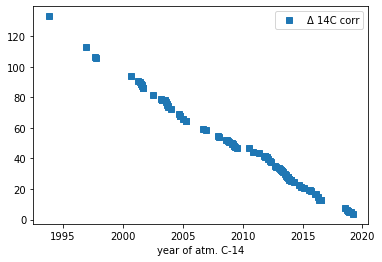

In [82]:
c14_patient_data.plot('year of atm. C-14', 'Δ 14C corr', ls='None', marker='s')

In [83]:
c14_patient_data.to_excel('../../../data/C14data_liver_samples_20200330_fabian.xlsx', index=False)

## Convert data

In [84]:
c14_patient_data = c14_patient_data[
    ['sort', 'Code', 'sample', 'DOB', 'DOA', u'Δ 14C corr', 'Error, 2 s', 'no sorted', 'Pathology', 'sex']].copy()

c14_patient_data.columns = ['type', 'code', 'sample', 'Dbirth', 'Dcoll', 'd14C', 'e14C', 'N_cells', 'pathology', 'sex']

c14_patient_data['d14C'] /= 1000.0
c14_patient_data['e14C'] /= 1000.0 # convert unit
c14_patient_data['e14C'] /= 2.0 # convert to 1s error
c14_patient_data['subject_age'] = c14_patient_data['Dcoll'] - c14_patient_data['Dbirth']

def convert_N_cell_entry(x):
    if isinstance(x, float):
        return x
    elif x[-1] == '2':
        return float(x.rstrip(' mio /2')) / 2
    else:
        return float(x.rstrip(' mio'))

c14_patient_data['N_cells'] = c14_patient_data['N_cells'].apply(convert_N_cell_entry)

c14_patient_data.loc[c14_patient_data['type'] == 'HNF4α -', 'type'] = 'non-hepatocyte'

c14_patient_data['ploidy'] = '2n4n'
for type_ in ['2n', '4n']:
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'ploidy'] = type_
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'type'] = 'hepatocyte'


c14_patient_data['type'] = pd.Categorical(c14_patient_data['type'])
c14_patient_data['code'] = pd.Categorical(c14_patient_data['code'])
c14_patient_data['sample'] = pd.Categorical(c14_patient_data['sample'])
c14_patient_data['pathology'] = pd.Categorical(c14_patient_data['pathology'])

c14_patient_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,e14C,N_cells,pathology,sex,subject_age,ploidy
0,unsorted,PH95,HL#10,1932.916667,2017.583333,0.013000,0.00460,NaN,T,M,84.666667,2n4n
1,non-hepatocyte,PH94,HL#10,1932.916667,2017.583333,0.016500,0.00715,34.0,T,M,84.666667,2n4n
2,hepatocyte,MK 4,HL#11,1975.333333,2019.750000,0.041590,0.00685,12.0,T,F,44.416667,4n
3,hepatocyte,MK 3,HL#11,1975.333333,2019.750000,0.012959,0.00640,77.0,T,F,44.416667,2n
4,hepatocyte,MK 7,HL#12,1947.833333,2017.916667,0.024600,0.00660,59.0,T,F,70.083333,2n4n


Drop the patient with unknown age

In [85]:
c14_patient_data = c14_patient_data[c14_patient_data['Dbirth'].notna()]

In [86]:
c14_patient_data.to_csv(f'../data/C14data_liver_samples_20200330.csv', index=False)

# 20200313

In [3]:
c14_patient_data = pd.read_excel('../../../data/C14data_liver_samples_20200313.xlsx')[
    ['sort', 'Code', 'sample', 'DOB', 'DOA', u'Δ 14C', 'Error, 2 s', 'no sorted', 'Pathology', 'sex']]
c14_patient_data.columns = ['type', 'code', 'sample', 'Dbirth', 'Dcoll', 'd14C', 'e14C', 'N_cells', 'pathology', 'sex']

c14_patient_data['d14C'] /= 1000.0
c14_patient_data['e14C'] /= 1000.0 # convert unit
c14_patient_data['e14C'] /= 2.0 # convert to 1s error
c14_patient_data['subject_age'] = c14_patient_data['Dcoll'] - c14_patient_data['Dbirth']

def convert_N_cell_entry(x):
    if isinstance(x, float):
        return x
    elif x[-1] == '2':
        return float(x.rstrip(' mio /2')) / 2
    else:
        return float(x.rstrip(' mio'))

c14_patient_data['N_cells'] = c14_patient_data['N_cells'].apply(convert_N_cell_entry)

c14_patient_data.loc[c14_patient_data['type'] == 'HNF4α -', 'type'] = 'non-hepatocyte'

c14_patient_data['ploidy'] = '2n4n'
for type_ in ['2n', '4n']:
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'ploidy'] = type_
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'type'] = 'hepatocyte'


c14_patient_data['type'] = pd.Categorical(c14_patient_data['type'])
c14_patient_data['code'] = pd.Categorical(c14_patient_data['code'])
c14_patient_data['sample'] = pd.Categorical(c14_patient_data['sample'])
c14_patient_data['pathology'] = pd.Categorical(c14_patient_data['pathology'])

c14_patient_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,e14C,N_cells,pathology,sex,subject_age,ploidy
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,F,73.583333,2n4n
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,M,25.416667,2n4n
2,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,M,58.333333,2n4n
3,hepatocyte,PH7,ND023,1945.833333,2004.833333,0.090351,0.004395,70.0,N,M,59.000000,2n4n
4,hepatocyte,PH11,ND375,1992.500000,2016.333333,0.003700,0.016000,61.0,N,M,23.833333,2n4n


Drop the patient with unknown age

In [4]:
c14_patient_data = c14_patient_data[c14_patient_data['Dbirth'].notna()]

In [4]:
c14_patient_data.to_csv(f'../data/C14data_liver_samples_20200312.csv', index=False)

# 20200227

In [3]:
c14_patient_data = pd.read_excel('../../../data/C14data_liver_samples_20200227.xlsx')[
    ['sort', 'Code', 'sample', 'DOB', 'DOA', u'Δ 14C', 'Error, 2 s', 'no sorted', 'Pathology', 'sex']]
c14_patient_data.columns = ['type', 'code', 'sample', 'Dbirth', 'Dcoll', 'd14C', 'e14C', 'N_cells', 'pathology', 'sex']

c14_patient_data['d14C'] /= 1000.0
c14_patient_data['e14C'] /= 1000.0 # convert unit
c14_patient_data['e14C'] /= 2.0 # convert to 1s error
c14_patient_data['subject_age'] = c14_patient_data['Dcoll'] - c14_patient_data['Dbirth']

def convert_N_cell_entry(x):
    if isinstance(x, float):
        return x
    elif x[-1] == '2':
        return float(x.rstrip(' mio /2')) / 2
    else:
        return float(x.rstrip(' mio'))

c14_patient_data['N_cells'] = c14_patient_data['N_cells'].apply(convert_N_cell_entry)

c14_patient_data.loc[c14_patient_data['type'] == 'HNF4α -', 'type'] = 'non-hepatocyte'

c14_patient_data['ploidy'] = '2n4n'
for type_ in ['2n', '4n']:
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'ploidy'] = type_
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'type'] = 'hepatocyte'


c14_patient_data['type'] = pd.Categorical(c14_patient_data['type'])
c14_patient_data['code'] = pd.Categorical(c14_patient_data['code'])
c14_patient_data['sample'] = pd.Categorical(c14_patient_data['sample'])
c14_patient_data['pathology'] = pd.Categorical(c14_patient_data['pathology'])

c14_patient_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,e14C,N_cells,pathology,sex,subject_age,ploidy
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,F,73.583333,2n4n
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,M,25.416667,2n4n
2,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,M,58.333333,2n4n
3,hepatocyte,PH7,ND023,1945.833333,2004.833333,0.090351,0.004395,70.0,N,M,59.000000,2n4n
4,hepatocyte,PH11,ND375,1992.500000,2016.333333,0.003700,0.016000,61.0,N,M,23.833333,2n4n


Drop the patient with unknown age

In [4]:
c14_patient_data = c14_patient_data[c14_patient_data['Dbirth'].notna()]

In [5]:
c14_patient_data.to_csv(f'../data/C14data_liver_samples_20200227.csv', index=False)

# 20200129

In [3]:
c14_patient_data = pd.read_excel('../../../data/C14data_liver_samples_20200129.xlsx')[
    ['sort', 'Code', 'sample', 'DOB', 'DOA', u'Δ 14C', 'Error, 2 s', 'no sorted', 'Pathology', 'sex']]
c14_patient_data.columns = ['type', 'code', 'sample', 'Dbirth', 'Dcoll', 'd14C', 'e14C', 'N_cells', 'pathology', 'sex']

c14_patient_data['d14C'] /= 1000.0
c14_patient_data['e14C'] /= 1000.0 # convert unit
c14_patient_data['e14C'] /= 2.0 # convert to 1s error
c14_patient_data['subject_age'] = c14_patient_data['Dcoll'] - c14_patient_data['Dbirth']

def convert_N_cell_entry(x):
    if isinstance(x, float):
        return x
    elif x[-1] == '2':
        return float(x.rstrip(' mio /2')) / 2
    else:
        return float(x.rstrip(' mio'))

c14_patient_data['N_cells'] = c14_patient_data['N_cells'].apply(convert_N_cell_entry)

c14_patient_data.loc[c14_patient_data['type'] == 'HNF4α -', 'type'] = 'non-hepatocyte'

c14_patient_data['ploidy'] = '2n4n'
for type_ in ['2n', '4n']:
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'ploidy'] = type_
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'type'] = 'hepatocyte'


c14_patient_data['type'] = pd.Categorical(c14_patient_data['type'])
c14_patient_data['code'] = pd.Categorical(c14_patient_data['code'])
c14_patient_data['sample'] = pd.Categorical(c14_patient_data['sample'])
c14_patient_data['pathology'] = pd.Categorical(c14_patient_data['pathology'])

c14_patient_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,e14C,N_cells,pathology,sex,subject_age,ploidy
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,F,73.583333,2n4n
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,M,25.416667,2n4n
2,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,M,58.333333,2n4n
3,hepatocyte,PH7,ND023,1945.833333,2004.833333,0.090351,0.004395,70.0,N,M,59.000000,2n4n
4,hepatocyte,PH11,ND375,1992.500000,2016.333333,0.003700,0.016000,61.0,N,M,23.833333,2n4n


Drop the patient with unknown age

In [4]:
c14_patient_data = c14_patient_data[c14_patient_data['Dbirth'].notna()]

In [5]:
c14_patient_data.to_csv(f'../../../results/C14data_liver_samples_20200129.csv', index=False)
c14_patient_data.to_pickle(f'../../../results/C14data_liver_samples_20200129.pkl')

In [6]:
pd.read_pickle(f'../../../results/C14data_liver_samples_20200129.pkl').head()

,type,code,sample,Dbirth,Dcoll,d14C,e14C,N_cells,pathology,sex,subject_age,ploidy
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,F,73.583333,2n4n
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,M,25.416667,2n4n
2,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,M,58.333333,2n4n
3,hepatocyte,PH7,ND023,1945.833333,2004.833333,0.090351,0.004395,70.0,N,M,59.000000,2n4n
4,hepatocyte,PH11,ND375,1992.500000,2016.333333,0.003700,0.016000,61.0,N,M,23.833333,2n4n


# 20191023

In [2]:
c14_patient_data = pd.read_excel('../../../data/C14data_liver_samples_20191023.xlsx')[
    ['sort', 'Code', 'sample', 'DOB', 'DOA', u'Δ 14C', 'Error, 2 s', 'no sorted', 'Pathology', 'sex']]
c14_patient_data.columns = ['type', 'code', 'sample', 'Dbirth', 'Dcoll', 'd14C', 'e14C', 'N_cells', 'pathology', 'sex']

c14_patient_data['d14C'] /= 1000.0
c14_patient_data['e14C'] /= 1000.0 # convert unit
c14_patient_data['e14C'] /= 2.0 # convert to 1s error
c14_patient_data['subject_age'] = c14_patient_data['Dcoll'] - c14_patient_data['Dbirth']

def convert_N_cell_entry(x):
    if isinstance(x, float):
        return x
    elif x[-1] == '2':
        return float(x.rstrip(' mio /2')) / 2
    else:
        return float(x.rstrip(' mio'))

c14_patient_data['N_cells'] = c14_patient_data['N_cells'].apply(convert_N_cell_entry)

c14_patient_data.loc[c14_patient_data['type'] == 'HNF4α -', 'type'] = 'non-hepatocyte'

c14_patient_data['ploidy'] = '2n4n'
for type_ in ['2n', '4n']:
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'ploidy'] = type_
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'type'] = 'hepatocyte'


c14_patient_data['type'] = pd.Categorical(c14_patient_data['type'])
c14_patient_data['code'] = pd.Categorical(c14_patient_data['code'])
c14_patient_data['sample'] = pd.Categorical(c14_patient_data['sample'])
c14_patient_data['pathology'] = pd.Categorical(c14_patient_data['pathology'])

c14_patient_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,e14C,N_cells,pathology,sex,subject_age,ploidy
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,F,73.583333,2n4n
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,M,25.416667,2n4n
2,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,M,58.333333,2n4n
3,hepatocyte,PH7,ND023,1945.833333,2004.833333,0.090351,0.004395,70.0,N,M,59.000000,2n4n
4,hepatocyte,PH11,ND375,1992.500000,2016.333333,0.003700,0.016000,61.0,N,M,23.833333,2n4n


Drop the patient with unknown age

In [3]:
c14_patient_data = c14_patient_data[c14_patient_data['Dbirth'].notna()]

In [4]:
c14_patient_data.to_csv(f'../../../results/C14data_liver_samples_20191023.csv', index=False)
c14_patient_data.to_pickle(f'../../../results/C14data_liver_samples_20191023.pkl')

In [5]:
pd.read_pickle(f'../../../results/C14data_liver_samples_20191023.pkl').head()

,type,code,sample,Dbirth,Dcoll,d14C,e14C,N_cells,pathology,sex,subject_age,ploidy
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,F,73.583333,2n4n
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,M,25.416667,2n4n
2,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,M,58.333333,2n4n
3,hepatocyte,PH7,ND023,1945.833333,2004.833333,0.090351,0.004395,70.0,N,M,59.000000,2n4n
4,hepatocyte,PH11,ND375,1992.500000,2016.333333,0.003700,0.016000,61.0,N,M,23.833333,2n4n


# 20190827

In [14]:
c14_patient_data = pd.read_excel('../../../data/C14data_liver_samples_20190827.xlsx')[
    ['sort', 'Code', 'sample', 'DOB', 'DOA', u'Δ 14C', 'Error, 2 s', 'no sorted', 'Pathology', 'sex']]
c14_patient_data.columns = ['type', 'code', 'sample', 'Dbirth', 'Dcoll', 'd14C', 'e14C', 'N_cells', 'pathology', 'sex']

c14_patient_data['d14C'] /= 1000.0
c14_patient_data['e14C'] /= 1000.0 # convert unit
c14_patient_data['e14C'] /= 2.0 # convert to 1s error
c14_patient_data['subject_age'] = c14_patient_data['Dcoll'] - c14_patient_data['Dbirth']

def convert_N_cell_entry(x):
    if isinstance(x, float):
        return x
    elif x[-1] == '2':
        return float(x.rstrip(' mio /2')) / 2
    else:
        return float(x.rstrip(' mio'))

c14_patient_data['N_cells'] = c14_patient_data['N_cells'].apply(convert_N_cell_entry)

c14_patient_data.loc[c14_patient_data['type'] == 'HNF4α -', 'type'] = 'non-hepatocyte'

c14_patient_data['ploidy'] = '2n4n'
for type_ in ['2n', '4n']:
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'ploidy'] = type_
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'type'] = 'hepatocyte'


c14_patient_data['type'] = pd.Categorical(c14_patient_data['type'])
c14_patient_data['code'] = pd.Categorical(c14_patient_data['code'])
c14_patient_data['sample'] = pd.Categorical(c14_patient_data['sample'])
c14_patient_data['pathology'] = pd.Categorical(c14_patient_data['pathology'])

c14_patient_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,e14C,N_cells,pathology,sex,subject_age,ploidy
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,F,73.583333,2n4n
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,M,25.416667,2n4n
2,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,M,58.333333,2n4n
3,hepatocyte,PH7,ND023,1945.833333,2004.833333,0.090351,0.004395,70.0,N,M,59.000000,2n4n
4,hepatocyte,PH11,ND375,1992.500000,2016.333333,0.003700,0.016000,61.0,N,M,23.833333,2n4n


Drop the patient with unknown age

In [15]:
c14_patient_data = c14_patient_data[c14_patient_data['Dbirth'].notna()]

In [16]:
c14_patient_data.to_csv(f'../../../results/C14data_liver_samples_20190827.csv', index=False)
c14_patient_data.to_pickle(f'../../../results/C14data_liver_samples_20190827.pkl')

In [17]:
pd.read_pickle(f'../../../results/C14data_liver_samples_20190827.pkl').head()

,type,code,sample,Dbirth,Dcoll,d14C,e14C,N_cells,pathology,sex,subject_age,ploidy
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,F,73.583333,2n4n
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,M,25.416667,2n4n
2,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,M,58.333333,2n4n
3,hepatocyte,PH7,ND023,1945.833333,2004.833333,0.090351,0.004395,70.0,N,M,59.000000,2n4n
4,hepatocyte,PH11,ND375,1992.500000,2016.333333,0.003700,0.016000,61.0,N,M,23.833333,2n4n


# 20190722

In [5]:
c14_patient_data = pd.read_excel('../../../data/C14data_liver_samples_20190722.xlsx')[
    ['sort', 'Code', 'sample', 'DOB', 'DOA', u'Δ 14C', 'Error, 2 s', 'no sorted', 'Pathology']]
c14_patient_data.columns = ['type', 'code', 'sample', 'Dbirth', 'Dcoll', 'd14C', 'error_measurement', 'N_cells', 'pathology']

c14_patient_data['d14C'] /= 1000.0
c14_patient_data['error_measurement'] /= 1000.0 # convert unit
c14_patient_data['error_measurement'] /= 2.0 # convert to 1s error
c14_patient_data['subject_age'] = c14_patient_data['Dcoll'] - c14_patient_data['Dbirth']

def convert_N_cell_entry(x):
    if isinstance(x, float):
        return x
    elif x[-1] == '2':
        return float(x.rstrip(' mio /2')) / 2
    else:
        return float(x.rstrip(' mio'))

c14_patient_data['N_cells'] = c14_patient_data['N_cells'].apply(convert_N_cell_entry)

c14_patient_data.loc[c14_patient_data['type'] == 'HNF4α -', 'type'] = 'non-hepatocyte'

c14_patient_data['ploidy'] = '2n4n'
for type_ in ['2n', '4n']:
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'ploidy'] = type_
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'type'] = 'hepatocyte'


c14_patient_data['type'] = pd.Categorical(c14_patient_data['type'])
c14_patient_data['code'] = pd.Categorical(c14_patient_data['code'])
c14_patient_data['sample'] = pd.Categorical(c14_patient_data['sample'])
c14_patient_data['pathology'] = pd.Categorical(c14_patient_data['pathology'])

c14_patient_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,error_measurement,N_cells,pathology,subject_age,ploidy
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,73.583333,2n4n
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,25.416667,2n4n
2,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,58.333333,2n4n
3,hepatocyte,PH7,ND023,1945.833333,2004.833333,0.090351,0.004395,70.0,N,59.000000,2n4n
4,hepatocyte,PH11,ND375,1992.500000,2016.333333,0.003700,0.016000,61.0,N,23.833333,2n4n


Drop the patient with unknown age

In [7]:
c14_patient_data = c14_patient_data[c14_patient_data['Dbirth'].notna()]

In [9]:
c14_patient_data.to_csv(f'../../../results/C14data_liver_samples_20190722.csv', index=False)
c14_patient_data.to_pickle(f'../../../results/C14data_liver_samples_20190722.pkl')

In [12]:
pd.read_pickle(f'../../../results/C14data_liver_samples_20190722.pkl').head()

,type,code,sample,Dbirth,Dcoll,d14C,error_measurement,N_cells,pathology,subject_age,ploidy
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,73.583333,2n4n
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,25.416667,2n4n
2,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,58.333333,2n4n
3,hepatocyte,PH7,ND023,1945.833333,2004.833333,0.090351,0.004395,70.0,N,59.000000,2n4n
4,hepatocyte,PH11,ND375,1992.500000,2016.333333,0.003700,0.016000,61.0,N,23.833333,2n4n


# 20190502

In [16]:
c14_patient_data = pd.read_excel('../../data/C14data_liver_samples_20190502.xlsx')[
    ['sort', 'Code', 'sample', 'DOB', 'DOA', u'Δ 14C', 'Error, 2 s', 'no sorted', 'Pathology']]
c14_patient_data.columns = ['type', 'code', 'sample', 'Dbirth', 'Dcoll', 'd14C', 'error_measurement', 'N_cells', 'pathology']

c14_patient_data['d14C'] /= 1000.0
c14_patient_data['error_measurement'] /= 1000.0 # convert unit
c14_patient_data['error_measurement'] /= 2.0 # convert to 1s error
c14_patient_data['subject_age'] = c14_patient_data['Dcoll'] - c14_patient_data['Dbirth']

def convert_N_cell_entry(x):
    if isinstance(x, float):
        return x
    elif x[-1] == '2':
        return float(x.rstrip(' mio /2')) / 2
    else:
        return float(x.rstrip(' mio'))

c14_patient_data['N_cells'] = c14_patient_data['N_cells'].apply(convert_N_cell_entry)

c14_patient_data.loc[c14_patient_data['type'] == 'HNF4α -', 'type'] = 'non-hepatocyte'

c14_patient_data['ploidy'] = '2n4n'
for type_ in ['2n', '4n']:
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'ploidy'] = type_
    c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'type'] = 'hepatocyte'


c14_patient_data['type'] = pd.Categorical(c14_patient_data['type'])
c14_patient_data['code'] = pd.Categorical(c14_patient_data['code'])
c14_patient_data['sample'] = pd.Categorical(c14_patient_data['sample'])
c14_patient_data['pathology'] = pd.Categorical(c14_patient_data['pathology'])

c14_patient_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,error_measurement,N_cells,pathology,subject_age,ploidy
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,73.583333,2n4n
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,25.416667,2n4n
2,hepatocyte,PH3,ND381,1985.166667,2016.416667,0.040336,0.008788,58.0,N,31.250000,2n4n
3,hepatocyte,PH4,ND382,1982.083333,2016.500000,0.018815,0.005342,52.0,N,34.416667,2n4n
4,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,58.333333,2n4n


Drop the patient with unknown age

In [17]:
c14_patient_data = c14_patient_data[c14_patient_data['Dbirth'].notna()]

In [18]:
c14_patient_data.to_csv(f'../../results/C14data_liver_samples_20190502.csv', index=False)
c14_patient_data.to_pickle(f'../../results/C14data_liver_samples_20190502.pkl')

In [19]:
pd.read_csv(f'../../results/C14data_liver_samples_20190502.csv')['type'].head()

0      unsorted
1      unsorted
2    hepatocyte
3    hepatocyte
4    hepatocyte
Name: type, dtype: object

In [20]:
pd.read_pickle(f'../../results/C14data_liver_samples_20190502.pkl')['type'].head()

0      unsorted
1      unsorted
2    hepatocyte
3    hepatocyte
4    hepatocyte
Name: type, dtype: category
Categories (3, object): [hepatocyte, non-hepatocyte, unsorted]

In [21]:
pd.read_pickle(f'../../results/C14data_liver_samples_20190502.pkl').head()

,type,code,sample,Dbirth,Dcoll,d14C,error_measurement,N_cells,pathology,subject_age,ploidy
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,73.583333,2n4n
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,25.416667,2n4n
2,hepatocyte,PH3,ND381,1985.166667,2016.416667,0.040336,0.008788,58.0,N,31.250000,2n4n
3,hepatocyte,PH4,ND382,1982.083333,2016.500000,0.018815,0.005342,52.0,N,34.416667,2n4n
4,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,58.333333,2n4n


# Old

In [ ]:
# # 20180505

# c14_patient_data = pd.read_excel('../../data/C14data_liver_samples_20180505.xlsx', 
#                                  usecols=[0, 1, 2, 3, 5, 6, 8, 9, 10])[
#     ['sort', 'Code', 'sample', 'DOB', 'DOA', u'Δ 14C', 'Error, 2 s', 'no sorted', 'Pathology']]
# c14_patient_data.columns = ['type', 'code', 'sample', 'Dbirth', 'Dcoll', 'd14C', 'error_measurement', 'N_cells', 'pathology']

# c14_patient_data['d14C'] /= 1000.0
# c14_patient_data['error_measurement'] /= 1000.0 # convert unit
# c14_patient_data['error_measurement'] /= 2.0 # convert to 1s error
# c14_patient_data['subject_age'] = c14_patient_data['Dcoll'] - c14_patient_data['Dbirth']

# invalid_codes = ['PH14', 'PH20', 'PH45', 'PH46']
# c14_patient_data['valid'] = np.logical_not(c14_patient_data['code'].isin(invalid_codes))

# c14_patient_data['type'] = pd.Categorical(c14_patient_data['type'])
# c14_patient_data['code'] = pd.Categorical(c14_patient_data['code'])
# c14_patient_data['sample'] = pd.Categorical(c14_patient_data['sample'])
# c14_patient_data['pathology'] = pd.Categorical(c14_patient_data['pathology'])

# def convert_N_cell_entry(x):
#     if isinstance(x, float):
#         return x
#     elif x[-1] == '2':
#         return float(x.rstrip(' mio /2')) / 2
#     else:
#         return float(x.rstrip(' mio'))

# c14_patient_data['N_cells'] = c14_patient_data['N_cells'].apply(convert_N_cell_entry)

# c14_patient_data.loc[c14_patient_data['type'] == 'HNF4α -', 'type'] = 'non-hepatocyte'
# c14_patient_data['type'].cat.remove_unused_categories(inplace=True)
    
# c14_patient_data.head()

# c14_patient_data.to_csv(f'../../results/C14data_liver_samples_{datetime.date.today().isoformat()}.csv', index=False)
# c14_patient_data.to_pickle(f'../../results/C14data_liver_samples_{datetime.date.today().isoformat()}.pkl')

# pd.read_csv('../../results/C14data_liver_samples_2018-12-05.csv')['type'].head()

# pd.read_pickle('../../results/C14data_liver_samples_2018-12-05.pkl')['type'].head()

# # 20190307

# c14_patient_data = pd.read_excel('../../data/C14data_liver_samples_20190307.xlsx', 
#                                  usecols=[0, 1, 2, 3, 5, 6, 8, 9, 10])[
#     ['sort', 'Code', 'sample', 'DOB', 'DOA', u'Δ 14C', 'Error, 2 s', 'no sorted', 'Pathology']]
# c14_patient_data.columns = ['type', 'code', 'sample', 'Dbirth', 'Dcoll', 'd14C', 'error_measurement', 'N_cells', 'pathology']

# c14_patient_data['d14C'] /= 1000.0
# c14_patient_data['error_measurement'] /= 1000.0 # convert unit
# c14_patient_data['error_measurement'] /= 2.0 # convert to 1s error
# c14_patient_data['subject_age'] = c14_patient_data['Dcoll'] - c14_patient_data['Dbirth']

# # invalid_codes = ['PH14', 'PH20', 'PH45', 'PH46']
# # c14_patient_data['valid'] = np.logical_not(c14_patient_data['code'].isin(invalid_codes))

# c14_patient_data['type'] = pd.Categorical(c14_patient_data['type'])
# c14_patient_data['code'] = pd.Categorical(c14_patient_data['code'])
# c14_patient_data['sample'] = pd.Categorical(c14_patient_data['sample'])
# c14_patient_data['pathology'] = pd.Categorical(c14_patient_data['pathology'])

# def convert_N_cell_entry(x):
#     if isinstance(x, float):
#         return x
#     elif x[-1] == '2':
#         return float(x.rstrip(' mio /2')) / 2
#     else:
#         return float(x.rstrip(' mio'))

# c14_patient_data['N_cells'] = c14_patient_data['N_cells'].apply(convert_N_cell_entry)

# c14_patient_data.loc[c14_patient_data['type'] == 'HNF4α -', 'type'] = 'non-hepatocyte'
# c14_patient_data['type'].cat.remove_unused_categories(inplace=True)
    
# c14_patient_data.head()

# Drop the patient with unknown age

# c14_patient_data[c14_patient_data.drop('N_cells', axis=1).isna().any(axis='columns')]

# c14_patient_data = c14_patient_data[c14_patient_data['Dbirth'].notna()]

# c14_patient_data.to_csv(f'../../results/C14data_liver_samples_{datetime.date.today().isoformat()}.csv', index=False)
# c14_patient_data.to_pickle(f'../../results/C14data_liver_samples_{datetime.date.today().isoformat()}.pkl')

# pd.read_csv('../../results/C14data_liver_samples_2019-03-22.csv')['type'].head()

# pd.read_pickle('../../results/C14data_liver_samples_2019-03-22.pkl')['type'].head()

# # 20190326

# pd.read_excel('../../data/C14data_liver_samples_20190326.xlsx').head()

# c14_patient_data = pd.read_excel('../../data/C14data_liver_samples_20190326.xlsx')[
#     ['sort', 'Code', 'sample', 'DOB', 'DOA', u'Δ 14C', 'Error, 2 s', 'no sorted', 'Pathology']]
# c14_patient_data.columns = ['type', 'code', 'sample', 'Dbirth', 'Dcoll', 'd14C', 'error_measurement', 'N_cells', 'pathology']

# c14_patient_data['d14C'] /= 1000.0
# c14_patient_data['error_measurement'] /= 1000.0 # convert unit
# c14_patient_data['error_measurement'] /= 2.0 # convert to 1s error
# c14_patient_data['subject_age'] = c14_patient_data['Dcoll'] - c14_patient_data['Dbirth']

# def convert_N_cell_entry(x):
#     if isinstance(x, float):
#         return x
#     elif x[-1] == '2':
#         return float(x.rstrip(' mio /2')) / 2
#     else:
#         return float(x.rstrip(' mio'))

# c14_patient_data['N_cells'] = c14_patient_data['N_cells'].apply(convert_N_cell_entry)

# c14_patient_data.loc[c14_patient_data['type'] == 'HNF4α -', 'type'] = 'non-hepatocyte'

# c14_patient_data['ploidy'] = '2n4n'
# for type_ in ['2n', '4n']:
#     c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'ploidy'] = type_
#     c14_patient_data.loc[c14_patient_data['type'].str.startswith(type_), 'type'] = 'hepatocyte'


# c14_patient_data['type'] = pd.Categorical(c14_patient_data['type'])
# c14_patient_data['code'] = pd.Categorical(c14_patient_data['code'])
# c14_patient_data['sample'] = pd.Categorical(c14_patient_data['sample'])
# c14_patient_data['pathology'] = pd.Categorical(c14_patient_data['pathology'])

# c14_patient_data.head()

# Drop the patient with unknown age

# c14_patient_data = c14_patient_data[c14_patient_data['Dbirth'].notna()]

# c14_patient_data.to_csv(f'../../results/C14data_liver_samples_{datetime.date.today().isoformat()}.csv', index=False)
# c14_patient_data.to_pickle(f'../../results/C14data_liver_samples_{datetime.date.today().isoformat()}.pkl')

# pd.read_csv('../../results/C14data_liver_samples_2019-04-05.csv')['type'].head()

# pd.read_pickle('../../results/C14data_liver_samples_2019-04-05.pkl')['type'].head()

# pd.read_pickle('../../results/C14data_liver_samples_2019-04-05.pkl').head()

